In [1]:
import numpy as np
from qutip import *
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

In [2]:
from modules.spin_arch import *
from modules.su_algebra import *

In [3]:
from IPython.display import Latex

In [4]:
Ntrunc = 4 #global operator for truncation level or total number of dimensions

In [ ]:
#entire process involves 3 steps
## 1) Evolution by H
## 2) Encoding \theta by applying U = e^{iJ\theta}
## 3) Measurement using some projections

### Hamiltonian: 
$$
H' = \sum_{n,i} \left(\frac{(g^n_{i-1})^2 \mathcal H(i)}{v^n_{i-1} - \omega} + v^n_i - \Delta_i \right) \sigma^n_{i,i} +  \frac{1}{2} \sum_{n \neq m,i}\frac{g^n_{i}g^m_{i}}{\omega - v^m_{i}} ( \sigma^n_{i,i+1}\sigma^m_{i+1,i} + \sigma^n_{i+1,i}\sigma^m_{i,i+1} )
$$

where $\mathcal H(i) = 1$ for $i>0$, otherwise 0.

### Parameters:
$$v^n_{i-1} = (\sqrt{8 E^n_c E^n_j})i - 0.5*E^n_c i (i+1) $$
with default values set as $v \approx 60 * 100Mhz$, $g = 100Mhz$, $\omega = 55*100MHz$ 

In [5]:
#initialize system
N = 4
Nlevel = Ntrunc
Ej, Ec, g_arr, omega = generate_tmon_arch(N,Nlevel)
sys1 = tmon_system(N, Nlevel, Ec, Ej, g_arr, omega)

In [6]:
sys1.freq_list()

[[0.0, 60.745553203367585, 118.99110640673517],
 [0.0, 60.745553203367585, 118.99110640673517],
 [0.0, 60.745553203367585, 118.99110640673517],
 [0.0, 60.745553203367585, 118.99110640673517]]

In [7]:
sys1.self_energy

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

### Hamiltonian Evolution: $$e^{-iHt} \rho_0 e^{iHt}$$

In [8]:
psi_2 = (basis(4,0) + basis(4,1))
psi_2 = psi_2/psi_2.norm()
psi_2 = psi_2 * psi_2.dag()
psi_2

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.5 0.5 0.  0. ]
 [0.5 0.5 0.  0. ]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]]

In [11]:
#(1)
#Evolution of a particular \rho with H' and \t
#simply solve the U\rhoU' for different thetas
H = sys1.H_I()
print(sys1.self_energy)
psi0 = tensor([psi_2]*N) #sys1.tensor_projection_op(0,1,1, dim = None)
times = np.linspace(0,200,400) #time scale is ~ 1/freq of self energy 
options = Options()
options.store_final_state = True
result = mesolve(H, psi0, times, [], options = options, progress_bar=True)
print(len(result.states))

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
10.0%. Run time:   0.13s. Est. time left: 00:00:00:01
20.0%. Run time:   0.22s. Est. time left: 00:00:00:00
30.0%. Run time:   0.32s. Est. time left: 00:00:00:00
40.0%. Run time:   0.40s. Est. time left: 00:00:00:00
50.0%. Run time:   0.48s. Est. time left: 00:00:00:00
60.0%. Run time:   0.59s. Est. time left: 00:00:00:00
70.0%. Run time:   0.67s. Est. time left: 00:00:00:00
80.0%. Run time:   0.77s. Est. time left: 00:00:00:00
90.0%. Run time:   0.85s. Est. time left: 00:00:00:00
Total run time:   0.94s
400


  0%|          | 0/4 [00:00<?, ?it/s]

Text(0, 0.5, 'n')

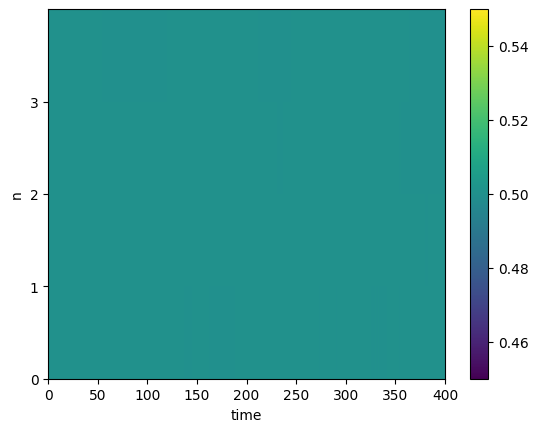

In [12]:
pop_arr = []
Jx_arr = []
for i in tqdm(range(N)):
    temp = []
    temp2 = []
    for state in result.states:
        temp.append(abs(expect(state.ptrace(i), create(Nlevel)*destroy(Nlevel))))
        temp2.append(abs(expect(state.ptrace(i),Qobj((op_padded(sigmax(),Nlevel))))))
    pop_arr.append(temp)
    Jx_arr.append(temp2)
    #print(sum(temp))
    
plt.pcolormesh(pop_arr)
plt.colorbar()
#plt.xticks()
plt.yticks(range(N))
plt.xlabel("time")
plt.ylabel("n")

Text(0, 0.5, 'index of tmons')

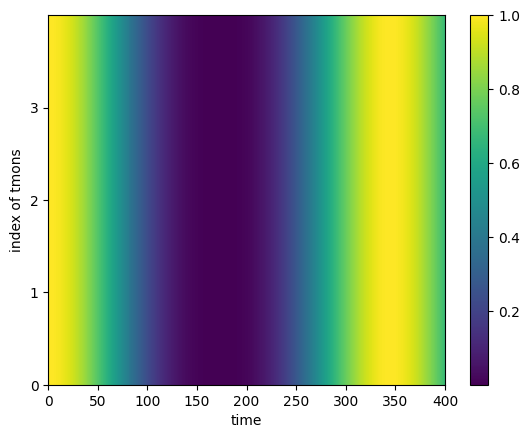

In [13]:
plt.pcolormesh(Jx_arr)
plt.colorbar()
#plt.xticks(times[times%5==0])
plt.yticks(range(N))
plt.xlabel("time")
plt.ylabel("index of tmons")

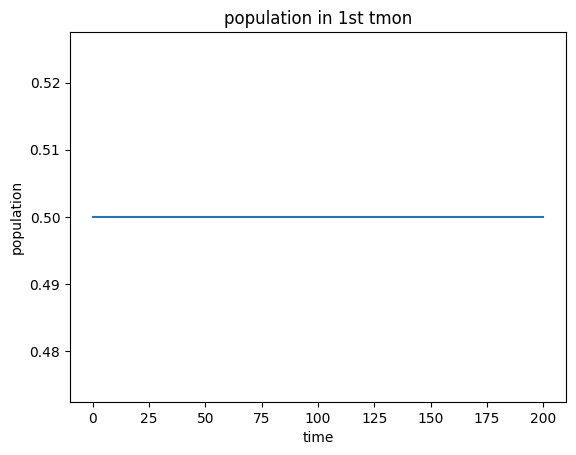

In [14]:
plt.plot(times, pop_arr[0])
plt.title("population in 1st tmon")
plt.xlabel("time")
plt.ylabel("population")
plt.show()

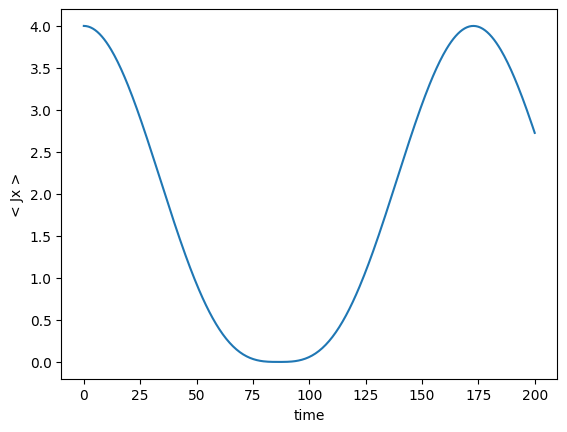

In [15]:
plt.plot(times, np.add(np.add(np.add(Jx_arr[0], Jx_arr[1]),Jx_arr[2]), Jx_arr[3]))
plt.xlabel("time")
plt.ylabel("< Jx >")
plt.show()

In [ ]:
result.states[80].ptrace(0)

### For pure states: $$F_{\psi} = 4 \Delta J^2_n = nCn^T \quad \quad C_{\alpha,\beta} = Cov<J_\alpha, J_\beta> = \frac{1}{2}[<J_\alpha J_\beta>+ <J_\beta J_\alpha>] - <J_\alpha><J_\beta>$$ where: $$<O> = Tr(\rho O) $$

In [39]:
#pauli matrices assuming just qubits
#no padding req for 2 dim though
Jx = Qobj(0.5*ensemble_op(op_padded(sigmax(),Nlevel), N))
Jy = Qobj(0.5*ensemble_op(op_padded(sigmay(),Nlevel), N))
Jz = Qobj(0.5*ensemble_op(op_padded(sigmaz(),Nlevel), N))

J_arr = [Jx,Jy,Jz]

In [49]:
#spin1 using tensor operators, but only Sx,Sy,Sz
sx,sy,sz, s1,s2,s3,s4,s5 = spin1_tensorop()
Jx = Qobj(ensemble_op(op_padded(sx,Nlevel), N))
Jy = Qobj(ensemble_op(op_padded(sy,Nlevel), N))
Jz = Qobj(ensemble_op(op_padded(sz,Nlevel), N))
J1 = Qobj(ensemble_op(op_padded(s1,Nlevel), N))
J2 = Qobj(ensemble_op(op_padded(s2,Nlevel), N))
J3 = Qobj(ensemble_op(op_padded(s3,Nlevel), N))
J4 = Qobj(ensemble_op(op_padded(s4,Nlevel), N))
J5 = Qobj(ensemble_op(op_padded(s5,Nlevel), N))

J_arr = [Jx,Jy,Jz,J1,J2,J3,J4,J5]

In [40]:
Qobj(op_padded(sigmax(),Nlevel)).eigenenergies()

array([-1.,  1.,  1.,  1.])

In [22]:
#Calculation of covariance matrix
# for now step (2,3) can be avoided as exact analytical results avaialble
# FI = n^T C n
def C_matrix(rho, J_arr):
    #do a dimension check for rho and J_arr[i] as well
    d = len(J_arr)
    C = np.zeros((d,d), dtype=complex)
    for i in range(d):
        for j in range(d):
            C[i][j] = 0.5*((rho*J_arr[i]*J_arr[j]).tr()+ (rho*J_arr[j]*J_arr[i]).tr())- (rho*J_arr[i]).tr()*(rho*J_arr[j]).tr()
    return C

In [50]:
#Maximum Eigenvalue
#when n is the eigenvector with maximum eigen value of C, FI is maximized
# Define the matrix
FI_max_arr = []
optimal_evec = []
i = 0
for state in tqdm(result.states):
    matrix = C_matrix(state, J_arr)
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    print(str(i) + "time step: " + str(np.around(eigenvalues.real, 4)))
    max_index = np.argmax(eigenvalues)
    max_eigenvalue = eigenvalues[max_index]
    max_eigenvector = eigenvectors[max_index]
    FI_max_arr.append(4*max_eigenvalue)
    optimal_evec.append(max_eigenvector)
    i = i+1



  0%|          | 0/400 [00:00<?, ?it/s]

0time step: [ 0. -0.  0.  0.  4.  0.  0.  0.]
1time step: [-0.0898  0.      0.0898  4.      0.      0.      0.      0.    ]
2time step: [-0.1788  0.      0.1787  4.      0.      0.      0.      0.    ]
3time step: [-0.2677  0.      0.2676  4.0001  0.      0.      0.      0.    ]
4time step: [-0.3565  0.      0.3561  4.0004  0.      0.      0.      0.    ]
5time step: [-0.445   0.      0.4441  4.0009  0.      0.      0.      0.    ]
6time step: [-0.5333 -0.      0.5313  4.0019  0.      0.      0.      0.    ]
7time step: [-0.6212 -0.      0.6176  4.0036  0.      0.      0.      0.    ]
8time step: [-0.7089 -0.      0.7027  4.0062  0.      0.      0.      0.    ]
9time step: [-0.7963 -0.      0.7864  4.0099  0.      0.      0.      0.    ]
10time step: [-0.8833 -0.      0.8682  4.0151  0.      0.      0.      0.    ]
11time step: [-0.9701  0.      0.9479  4.0222  0.      0.      0.      0.    ]
12time step: [-1.0566  0.      1.0252  4.0315  0.      0.      0.      0.    ]
13time step: [-

106time step: [-9.3073 10.5078  0.      2.7995  0.      0.      0.      0.    ]
107time step: [-9.3367 10.5009  0.      2.8358  0.      0.      0.      0.    ]
108time step: [-9.3638 10.4918 -0.      2.872   0.      0.      0.      0.    ]
109time step: [-9.3886 10.4805  0.      2.9081  0.      0.      0.      0.    ]
110time step: [-9.411  10.4671 -0.      2.9439  0.      0.      0.      0.    ]
111time step: [-9.431  10.4515  0.      2.9795  0.      0.      0.      0.    ]
112time step: [-9.4487 10.4337 -0.      3.0149  0.      0.      0.      0.    ]
113time step: [-9.4639 10.4139  0.      3.0501  0.      0.      0.      0.    ]
114time step: [-9.4769 10.392   0.      3.0849  0.      0.      0.      0.    ]
115time step: [-9.4874 10.368   0.      3.1194  0.      0.      0.      0.    ]
116time step: [-9.4956 10.342   0.      3.1536  0.      0.      0.      0.    ]
117time step: [-9.5014 10.3139  0.      3.1874  0.      0.      0.      0.    ]
118time step: [-9.5048 10.284  -0.      

210time step: [-9.2348  9.5376 -0.      3.6972  0.      0.      0.      0.    ]
211time step: [-9.2666  9.5924 -0.      3.6741  0.      0.      0.      0.    ]
212time step: [-9.2967  9.6464  0.      3.6502  0.      0.      0.      0.    ]
213time step: [-9.325   9.6994 -0.      3.6256  0.      0.      0.      0.    ]
214time step: [-9.3514  9.7513 -0.      3.6001  0.      0.      0.      0.    ]
215time step: [-9.376  9.802  0.     3.574  0.     0.     0.     0.   ]
216time step: [-9.3985  9.8515 -0.      3.5471  0.      0.      0.      0.    ]
217time step: [-9.4191  9.8996 -0.      3.5195  0.      0.      0.      0.    ]
218time step: [-9.4376  9.9463 -0.      3.4913  0.      0.      0.      0.    ]
219time step: [-9.4539  9.9915 -0.      3.4624  0.      0.      0.      0.    ]
220time step: [-9.4681 10.0352 -0.      3.4329  0.      0.      0.      0.    ]
221time step: [-9.4801 10.0772 -0.      3.4028  0.      0.      0.      0.    ]
222time step: [-9.4898 10.1176 -0.      3.3722  

320time step: [-2.1573  4.5098  0.      1.6475  0.      0.      0.      0.    ]
321time step: [-2.0691  4.4412  0.      1.6279  0.      0.      0.      0.    ]
322time step: [-1.9814  4.3782  0.      1.6032  0.      0.      0.      0.    ]
323time step: [-1.8942  4.3209  0.      1.5733  0.      0.      0.      0.    ]
324time step: [-1.8073  4.2693  0.      1.5381  0.      0.      0.      0.    ]
325time step: [-1.7208  4.2233  0.      1.4974  0.      0.      0.      0.    ]
326time step: [ 4.1829 -1.6344  0.      1.4515  0.      0.      0.      0.    ]
327time step: [ 4.1478 -1.5482  0.      1.4005  0.      0.      0.      0.    ]
328time step: [ 4.1177 -1.4622  0.      1.3445  0.      0.      0.      0.    ]
329time step: [ 4.0922 -1.3761  0.      1.2839  0.      0.      0.      0.    ]
330time step: [ 4.071 -1.29  -0.     1.219  0.     0.     0.     0.   ]
331time step: [-1.2038 -0.      1.1502  4.0536  0.      0.      0.      0.    ]
332time step: [-1.1174  0.      1.0779  4.0396  

In [57]:
optimal_evec[100]

array([-4.85054737e-17-3.95902221e-01j,  6.93655994e-01+0.00000000e+00j,
        5.77350269e-01-4.45532463e-17j,  9.64033971e-02+7.62469341e-17j,
        1.13118494e-16+4.50965696e-16j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j])

Text(0, 0.5, 'F_max')

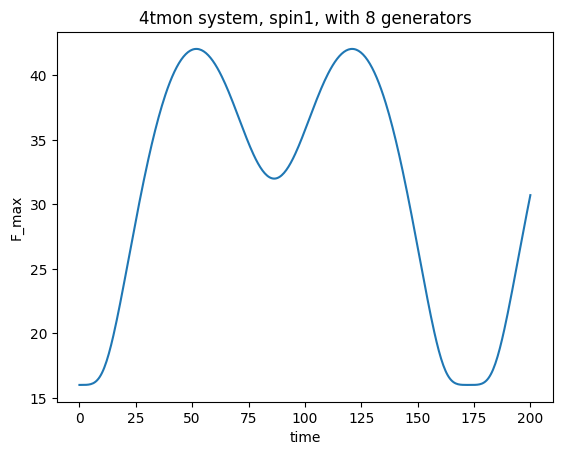

In [51]:
#Plot FI_max vs time/\theta
#plt.figure(figsize=(15,10))
plt.plot(times,FI_max_arr)
plt.title(str(N) + "tmon system, spin1, with 8 generators")
plt.xlabel("time")
plt.ylabel("F_max")

In [52]:
def is_hermitian(matrix):
    return np.allclose(matrix, matrix.conj().T)

def cartesian_to_spherical(vec):
    """Converts a cartesian coordinate (x, y, z) into a spherical one (radius, theta, phi)."""
    x = vec[0]
    y = vec[1]
    z = vec[2]
    radius = np.sqrt(x * x + y * y + z * z)
    theta = math.atan2(np.sqrt(x * x + y * y), z)
    #theta = math.acos(z/radius)
    phi = math.atan2(y, x)
    return [radius, theta, phi]

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

In [56]:
C_matrix(result.states[100], J_arr)

array([[ 9.52686752e+00-3.33066907e-16j, -8.93608133e-17-2.99794903e-17j,
         2.77555756e-17-2.77555756e-17j,  0.00000000e+00+0.00000000e+00j,
         2.66453526e-15+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        -1.44294307e-16+9.52686752e+00j,  0.00000000e+00+0.00000000e+00j],
       [-8.93608133e-17-2.99794903e-17j,  9.62696240e+00-2.77555756e-16j,
        -3.55991033e+00-1.66533454e-16j,  0.00000000e+00+0.00000000e+00j,
         2.46519033e-31-7.39557099e-32j,  0.00000000e+00+0.00000000e+00j,
         5.29579851e-16+9.62696240e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 2.77555756e-17-2.77555756e-17j, -3.55991033e+00-1.66533454e-16j,
         4.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         3.33066907e-16-3.55991033e+00j,  0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e

In [58]:
np.around(optimal_evec[100], decimals=2)

array([-0.  -0.4j,  0.69+0.j ,  0.58-0.j ,  0.1 +0.j ,  0.  +0.j ,
        0.  +0.j ,  0.  +0.j ,  0.  +0.j ])

In [53]:
#plot for optimal eigenvectors
spherical_coordinates = []
for vec in optimal_evec:
    spherical_coordinates.append(cartesian_to_spherical(vec.real))

In [54]:
spherical_coordinates = np.array(spherical_coordinates) 

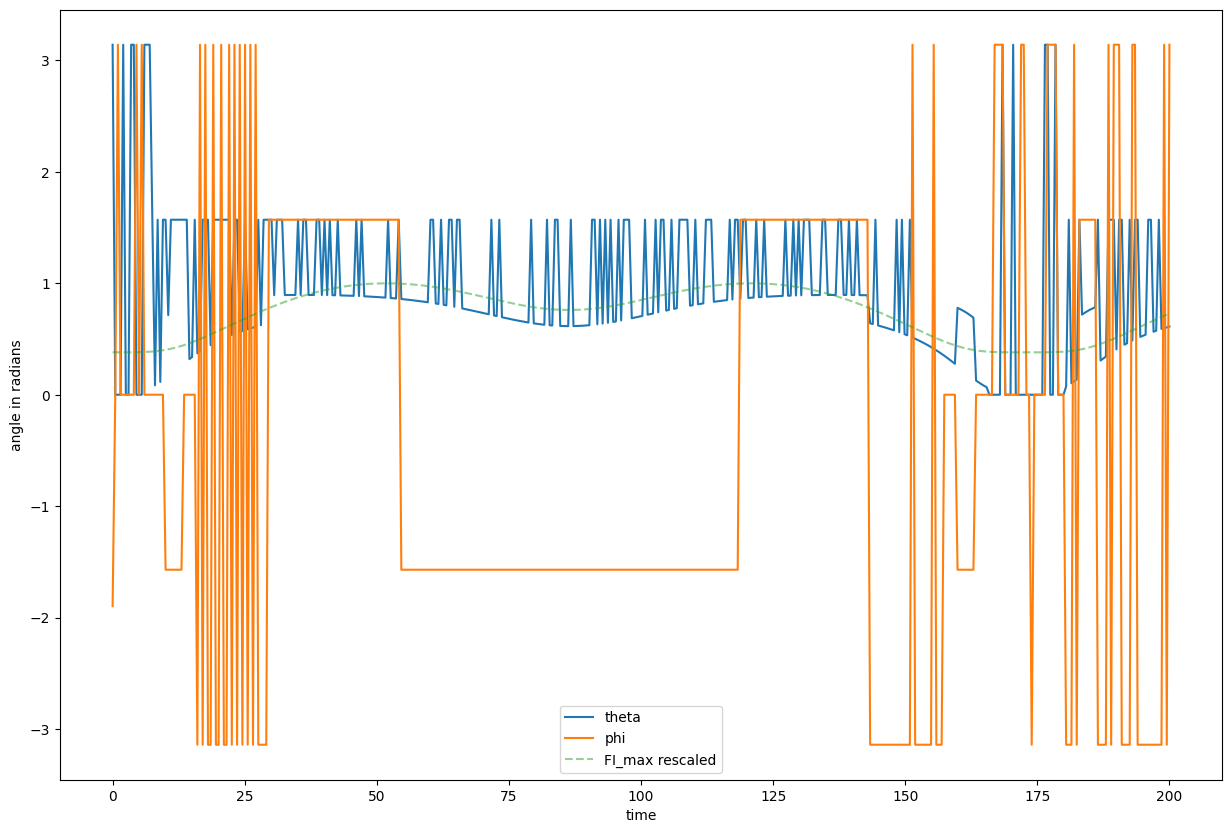

In [55]:
plt.figure(figsize=(15,10))
plt.plot(times,spherical_coordinates[:,1], label  = "theta")
plt.plot(times,spherical_coordinates[:,2], label = 'phi')
plt.plot(times,FI_max_arr/max(FI_max_arr),alpha =0.5 , label = "FI_max rescaled", linestyle='dashed')
plt.xlabel("time")
plt.ylabel("angle in radians")
plt.legend()

In [ ]:
#Graph of FI vs time


In [ ]:
#(2)
#Encode \theta by applying U = e^{i n.J \theta}
psi_i = results.states #for FI vs time graph
n = np.array([1,0,0]) #ideally the max eigenvalue eigenvector
J_arr = np.array([]) #generators or their subset
theta_arr = np.linspace(0, 0.5, 2) #values of theta to encode
#code for n.J
result2 = mesolve(n*J_arr, psi_i, times, [], options = options)

In [ ]:
#Fisher Info Calculation
def purestate_FI(J,psi):
    FI = 4*variance(J,psi)
    return FI

In [ ]:
FI_list = []
for psi in result.states:
    FI_list.append(purestate_FI(H,psi))

plt.plot(times,FI_list)
plt.xlabel("time")
plt.ylabel("Finsher Info")

In [ ]:
#pauli operators for the tmon system
#initialize
N = 3 #number of transmons
Nlevel = Ntrunc
# spin = 1
# dim = spin*2+1

#padded operators
jx = op_padded(jmat(spin,'x'), Nlevel)
jy = op_padded(jmat(spin,'y'), Nlevel)
jz = op_padded(jmat(spin,'z'), Nlevel)
#combined spin operators
JX = 0
JY = 0
JZ = 0
for i in range(N):
    JX.append(ensemble_op(jx,i,N))
    JY.append(ensemble_op(jx,i,N))
    JZ.append(ensemble_op(jx,i,N))

In [ ]:
#calculate optimal squeezing parameter
H_cap = [] #array of all operators being considered
##calculate covariance matrix
##calculate commutator matrix
def calculate_covariance(matrix1, matrix2):
    # Check if the matrices have the same shape
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same shape.")
    
    # Calculate the covariance
    covariance = np.cov(matrix1, matrix2, bias=True)
    
    return covariance

def covariance_matrix(H_cap):
    tau = np.zeros((len(H_cap),len(H_cap)))
    for k in range(len(H_cap)):
        for l in range(len(H_cap)):
            tau[k][l] = calculate_covariance(H_cap[k],H_cap(l))

In [ ]:
'''
#Hamiltonian for a set of transmons coupled to a mode
class tmon_system:
    def __init__(self,N, Nlevel, E_C, E_j, g_arr, omega):
        self.N = N #value of n goes from 0 to N-1
        self.Nlevel = Nlevel #cut off dimension/truncation
        #This is different from d which is the level that comes into hamiltonian.
        #d refers to the highest excitation present in the initialised state
        #d  by default is set to (Nlevel-2) as (d+1) at max can be (Nlevel-1)
        self.d = Nlevel-2
        self.E_c= E_c
        self.E_j = E_j
        self.g_arr = g_arr #g^n_i = g_arr[n][i]
        self.omega = omega #freq of photonic mode
        self.v_arr = self.freq_list() #v[n][i] = v^n_i
    
    def freq_list(self):
        #calculate v^n_i
        #for |i><i|_n, coefficient is  \sqrt(8E^n_j*E^n_c)*i - E^n_c/2*i(i+1)
        arr = []
        for n in range(self.N):
            temp_arr = []
            for i in range(self.d+1):
                v_ni = np.sqrt(8*self.E_c[n]*self.E_j[n])*i - 0.5*self.E_c[n]*i*(i+1)
                temp_arr.append(v_ni)
            arr.append(temp_arr) 
        return arr
    
    def cal_delta(self):
        #simplest version is to equate to average over transmons i.e n
        delta_arr = []
        
        for n in range(self.N):
            temp = 0
            for i in range(self.d +1):
                temp = temp + ((self.g_arr[n][i]**2)*np.heaviside(i,0)/(self.v_arr[n][i-1]-self.omega)+self.v_arr[n][i])
            delta_arr.append(temp/(self.d+1))
        return delta_arr
    
    def tensor_id(self, dim = None):
        if dim ==None:
            dim = self.d+2
        #IxIxIxI...Ioperator
        Neye = []
        for i in  range(self.N):
            Neye.append(qeye(dim))
        nid = tensor(Neye)
        return nid
          
    def tensor_projection_op(self,n,i,j, dim = None):
        #returns IxIxIx...(|i><j|_n)xIxI...xI
        if n > self.N-1:
            print("invalid n")
            return
        if dim ==None:
            dim = self.d+2
            
        Neye = []
        for k in  range(self.N):
            Neye.append(qeye(dim))
        #(|i><j|_n)
        Neye[n] = basis(dim,i)*basis(dim,j).dag()
        nid = tensor(Neye)
        return nid
        
    def H_I(self, delta_arr = None):
        #rotataed time indp effective hamiltonian
        #lambda_arr contains \Delta_i to be added as self energy corrections
        if delta_arr==None:
            delta_arr = self.cal_delta()
        
        H0 = 0
        for n in range(self.N):
            for i in range(self.d + 1):
                c_ni = (self.g_arr[n][i-1]**2)*np.heaviside(i,0)/(self.v_arr[n][i-1]- self.omega) + self.v_arr[n][i] - delta_arr[i]
                H0 = H0 + c_ni*self.tensor_projection_op(n,i,i)
        
        H1 = 0
        for n in range(self.N):
            for m in range(self.N):
                for i in range(self.d + 1):
                    if n == m:
                        break
                    c_nmi = 0.5*(self.g_arr[n][i]*self.g_arr[m][i])/(self.omega - self.v_arr[m][i])
                    H1 = H1 + c_nmi*(self.tensor_projection_op(n,i,i+1)*self.tensor_projection_op(m,i+1,i) + self.tensor_projection_op(n,i+1,i)*self.tensor_projection_op(m,i,i+1))
        
        return H0 + H1

def generate_tmon_arch(N,Nlevel):
    #scaling is 1 to 100MHz
    E_j =  np.absolute(np.random.normal(200,20, N))
    E_c = np.absolute(np.random.normal(2.5,0.2, N))
    g_arr = np.zeros((N,Nlevel))
    for n in range(N):
        for i in range(Nlevel):
            g_arr[n][i] = 1
    omega = 2
    return E_j, E_c, g_arr,omega 
'''

In [ ]:
"""
#create spin operators
class operators:
    def __init__(self, N, spin):
        self.N = N
        self.spin =spin
        
    
    def generators_arr(self):
        #return all generators for a spin-n algebra
        return
    
    def tensor_operator(self,op,i):
        #returns IxIxIx...(op_i)xIxI...xI
        if i > self.N-1:
            raise ValueError("index needs to be between 0 and"+str(self.N)+"-1")

        Neye = []
        for k in  range(self.N):
            Neye.append(qeye(self.spin))
        #(op_i)
        Neye[n] = basis(dim,i)*basis(dim,j).dag()
        nid = tensor(Neye)
        return nid
        
    def J_n(self,n):
        #\sum (n.J)_i
        #it should take both 3x1 and dx1 vectors
        #3x1 leads to use of just sigma x,y,z
        #dx1 leads to use of all generators
        jx = jmat(i, 'x')
        jy = jmat(i, 'y')
        jz = jmat(i, 'z')
        
        
     
    def nonlin_operators(self, degree):
        #take array of generators and combine them to get non-lin operators
        #return vector with non-lin operators only
        lin_op_arr = self.generators_arr
        nonlin_arr = []
"""